In [1]:
import itertools
import math
import gsd.hoomd
import hoomd
import numpy
import mbuild as mb
import numpy as np

class CC(mb.Compound):
    def __init__(self):
        super(CC, self).__init__()

        for i in range(10):
            self.add(mb.Particle(name="C", pos=[i,0,0]))
            if i>0:
                self.add_bond((self[-2],self[-1]))

CarbonBond = CC()
CarbonBond.visualize(show_ports=True)
CarbonBond.save('initial-state.gsd', overwrite=True)

/Users/joselyngutierrez/miniconda3/lib/python3.12/site-packages/foyer/forcefield.py:34: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import iter_entry_points, resource_filename
/Users/joselyngutierrez/miniconda3/lib/python3.12/site-packages/mbuild/packing.py:23: DeprecationWarning: Use shutil.which instead of find_executable
  PACKMOL = find_executable("packmol")


In [2]:
import os

fn = os.path.join(os.getcwd(), "lattice.gsd")
![ -e "$fn" ] && rm "$fn"
fn = os.path.join(os.getcwd(), "random.gsd")
![ -e "$fn" ] && rm "$fn"

/Users/joselyngutierrez/miniconda3/lib/python3.12/pty.py:95: DeprecationWarning: This process (pid=67538) is multi-threaded, use of forkpty() may lead to deadlocks in the child.
  pid, fd = os.forkpty()
/Users/joselyngutierrez/miniconda3/lib/python3.12/pty.py:95: DeprecationWarning: This process (pid=67538) is multi-threaded, use of forkpty() may lead to deadlocks in the child.
  pid, fd = os.forkpty()


In [3]:
# This is not intended as a full tutorial on fresnel - see the fresnel user
# documentation (https://fresnel.readthedocs.io/) if you would like to learn more.

import warnings

import fresnel
import IPython
import packaging.version

device = fresnel.Device()
tracer = fresnel.tracer.Path(device=device, w=300, h=300)

FRESNEL_MIN_VERSION = packaging.version.parse("0.13.0")
FRESNEL_MAX_VERSION = packaging.version.parse("0.14.0")


def render(snapshot):
    if (
        "version" not in dir(fresnel)
        or packaging.version.parse(fresnel.version.version) < FRESNEL_MIN_VERSION
        or packaging.version.parse(fresnel.version.version) >= FRESNEL_MAX_VERSION
    ):
        warnings.warn(
            f"Unsupported fresnel version {fresnel.version.version} - expect errors."
        )
    L = snapshot.configuration.box[0]
    scene = fresnel.Scene(device)
    geometry = fresnel.geometry.Sphere(
        scene, N=len(snapshot.particles.position), radius=0.5
    )
    geometry.material = fresnel.material.Material(
        color=fresnel.color.linear([252 / 255, 209 / 255, 1 / 255]), roughness=0.5
    )
    geometry.position[:] = snapshot.particles.position[:]
    geometry.outline_width = 0.04
    fresnel.geometry.Box(scene, [L, L, L, 0, 0, 0], box_radius=0.02)

    scene.lights = [
        fresnel.light.Light(direction=(0, 0, 1), color=(0.8, 0.8, 0.8), theta=math.pi),
        fresnel.light.Light(
            direction=(1, 1, 1), color=(1.1, 1.1, 1.1), theta=math.pi / 3
        ),
    ]
    scene.camera = fresnel.camera.Orthographic(
        position=(L * 2, L, L * 2), look_at=(0, 0, 0), up=(0, 1, 0), height=L * 1.4 + 1
    )
    scene.background_alpha = 1
    scene.background_color = (1, 1, 1)
    samples = 2000
    if "CI" in os.environ:
        samples = 100
    return IPython.display.Image(tracer.sample(scene, samples=samples)._repr_png_())

In [4]:
cpu = hoomd.device.CPU()
simulation = hoomd.Simulation(device=cpu, seed=1)
simulation.create_state_from_gsd(filename='initial-state.gsd')

In [5]:
integrator = hoomd.md.Integrator(dt=0.005)
cell = hoomd.md.nlist.Cell(buffer=0.4)
lj = hoomd.md.pair.LJ(nlist=cell)
lj.params[('C', 'C')] = dict(epsilon=1, sigma=1)
lj.r_cut[('C', 'C')] = 2.5
integrator.forces.append(lj)
nvt = hoomd.md.methods.ConstantVolume(
    filter=hoomd.filter.All(), thermostat=hoomd.md.methods.thermostats.Bussi(kT=1.5)
)
integrator.methods.append(nvt)

In [6]:
simulation.operations.integrator = integrator

In [7]:
snapshot = simulation.state.get_snapshot()
snapshot.particles.velocity[0:5]

array([[0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.]])

In [8]:
simulation.state.thermalize_particle_momenta(filter=hoomd.filter.All(), kT=1.5)

In [9]:
thermodynamic_properties = hoomd.md.compute.ThermodynamicQuantities(
    filter=hoomd.filter.All()
)

In [10]:
simulation.operations.computes.append(thermodynamic_properties)
simulation.run(0)

In [11]:
simulation.run(10000)

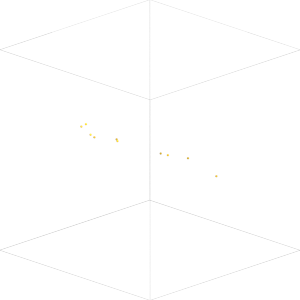

In [12]:
render(simulation.state.get_snapshot())

In [22]:
hoomd.write.GSD.write(state=simulation.state, filename='random.gsd', mode='xb')

In [ ]:
def end_to_end_distance(molecule):
    point_a = molecule[0].pos
    point_b = molecule[-1].pos
    return np.linalg.norm(point_a - point_b)

distance = end_to_end_distance(CarbonBond)
print(distance)